# Homework 1 - Finding Similar Items: Textually Similar Documents

### Environment Setup
Import the helper classes and set the working directory to `HW-1` to ensure downstream cells can access all required modules.
- Download the data from: https://github.com/vereesmort/data-mining.git (located in data-mining/HW-1/data)

In [1]:
import sys
import os

current_dir = os.getcwd()
if 'HW-1' not in current_dir:
    os.chdir('HW-1')
sys.path.insert(0, os.getcwd())

from main import (
    TextPreprocessor,
    Shingler,
    SetComparator,
    MinHasher,
    SignatureComparator,
    LSH
)

print("Imported all classes and functions from main.py")


Imported all classes and functions from main.py


### Configuration
Define dataset paths, shingle size, and hashing parameters (`k`, number of hash functions, LSH bands/rows)

In [2]:
# Configuration
data_dir = 'data'
k_shingle = 4
num_hash_functions = 300
num_bands = 30
rows_per_band = 10

text_files = ['text1.txt', 'text2.txt', 'text3.txt', 'text4.txt', 'text5.txt', 'text6.txt', 'text7.txt', 'text8.txt', 'text9.txt', 'text11.txt', 'text12.txt', 'text13.txt']
# text_files = ['text8.txt', 'text11.txt']

texts = {}

for filename in text_files:
    filepath = os.path.join(data_dir, filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        texts[filename] = f.read()
    print(f"Loaded {filename}: {len(texts[filename])} characters")


Loaded text1.txt: 3020 characters
Loaded text2.txt: 3326 characters
Loaded text3.txt: 6677 characters
Loaded text4.txt: 6277 characters
Loaded text5.txt: 3810 characters
Loaded text6.txt: 8519 characters
Loaded text7.txt: 3400 characters
Loaded text8.txt: 14646 characters
Loaded text9.txt: 3483 characters
Loaded text11.txt: 16141 characters
Loaded text12.txt: 5073 characters
Loaded text13.txt: 5575 characters


### Step 1: Text Preprocessing
Normalize each document (lowercasing only) to keep signal from punctuation and spacing while aligning case-sensitive shingles.


In [3]:
# Step 1: Preprocess texts
print("Step 1: Preprocessing texts...")
preprocessor = TextPreprocessor(remove_spaces=False, remove_symbols=False, lowercase=True)
preprocessed = {}

for filename, text in texts.items():
    preprocessed[filename] = preprocessor.preprocess(text)
    print(f"  {filename}: {len(preprocessed[filename])} characters after preprocessing")
print()


Step 1: Preprocessing texts...
  text1.txt: 3004 characters after preprocessing
  text2.txt: 3302 characters after preprocessing
  text3.txt: 6631 characters after preprocessing
  text4.txt: 6253 characters after preprocessing
  text5.txt: 3789 characters after preprocessing
  text6.txt: 8486 characters after preprocessing
  text7.txt: 3379 characters after preprocessing
  text8.txt: 14617 characters after preprocessing
  text9.txt: 3468 characters after preprocessing
  text11.txt: 16102 characters after preprocessing
  text12.txt: 5050 characters after preprocessing
  text13.txt: 5546 characters after preprocessing



### Step 2: Shingling
The shingling process is implemented in the `Shingler` class, which takes a preprocessed text string (optional: with spaces and symbols removed) and extracts all k-shingles using a sliding window approach. For memory efficiency, shingles are hashed to integer values using MD5, allowing the system to work with large documents without storing thousands of string objects.

In [4]:
# Step 2: Create shingles
print(f"Step 2: Creating {k_shingle}-shingles...")
shingler = Shingler(k=k_shingle)
shingle_sets = {}
shingle_hash_sets = {}

for filename, text in preprocessed.items():
    shingles = shingler.create_shingles(text)
    shingle_sets[filename] = shingles
    shingle_hash_sets[filename] = shingler.create_shingle_hashes(text)
    print(f"  {filename}: {len(shingles)} unique shingles")
print()


Step 2: Creating 4-shingles...
  text1.txt: 1886 unique shingles
  text2.txt: 2213 unique shingles
  text3.txt: 3555 unique shingles
  text4.txt: 3522 unique shingles
  text5.txt: 2220 unique shingles
  text6.txt: 4023 unique shingles
  text7.txt: 2060 unique shingles
  text8.txt: 5702 unique shingles
  text9.txt: 2163 unique shingles
  text11.txt: 6140 unique shingles
  text12.txt: 3057 unique shingles
  text13.txt: 3194 unique shingles



### Step 3: Jaccard Similarity
Compute pairwise Jaccard similarity across shingle sets to establish the ground-truth similarity ranking used to evaluate MinHash and LSH.
 
The Jaccard similarity between two sets A and B is computed as:

J(A, B) = |A ∩ B| / |A ∪ B|
 
- The intersection (A ∩ B) contains all shingles appearing in both documents.
- The union (A ∪ B) contains all unique shingles in either document.
 
This ratio gives the final Jaccard value between 0 and 1, where values closer to 1 indicate higher textual similarity.


In [5]:
# Step 3: Compare sets using Jaccard similarity
print("Step 3: Comparing sets using Jaccard similarity...")
set_comparator = SetComparator()
jaccard_similarities = set_comparator.compare_all_pairs(shingle_sets)

print("Jaccard Similarities (exact):")
for (doc1, doc2), sim in sorted(jaccard_similarities.items(), key=lambda x: x[1], reverse=True):
    print(f"  {doc1} vs {doc2}: {sim:.4f}")
print()


Step 3: Comparing sets using Jaccard similarity...
Jaccard Similarities (exact):
  text11.txt vs text8.txt: 0.9280
  text12.txt vs text4.txt: 0.4240
  text13.txt vs text6.txt: 0.4019
  text12.txt vs text9.txt: 0.3983
  text12.txt vs text2.txt: 0.3444
  text13.txt vs text2.txt: 0.3060
  text11.txt vs text6.txt: 0.2824
  text6.txt vs text8.txt: 0.2810
  text11.txt vs text3.txt: 0.2715
  text11.txt vs text4.txt: 0.2713
  text4.txt vs text8.txt: 0.2710
  text3.txt vs text8.txt: 0.2693
  text4.txt vs text6.txt: 0.2672
  text3.txt vs text4.txt: 0.2597
  text11.txt vs text9.txt: 0.2565
  text12.txt vs text13.txt: 0.2562
  text12.txt vs text3.txt: 0.2558
  text11.txt vs text13.txt: 0.2552
  text12.txt vs text6.txt: 0.2542
  text13.txt vs text8.txt: 0.2533
  text13.txt vs text3.txt: 0.2524
  text3.txt vs text6.txt: 0.2524
  text11.txt vs text12.txt: 0.2523
  text12.txt vs text8.txt: 0.2516
  text4.txt vs text5.txt: 0.2404
  text13.txt vs text4.txt: 0.2389
  text5.txt vs text6.txt: 0.2241
  text

### Step 4: MinHash Signature

MinHash works by generating multiple randomized hash functions of the form $(a x + b) \bmod p$, where each function maps shingles (representing k-grams) to a numeric value. For each hash function, the smallest hash value across all shingles in a document is recorded. Collecting these minimums across all hash functions yields a fixed-length signature vector for every document (e.g., 300 dimensions).


This process accomplishes two key things:
- It reduces each document's unique set of shingles into a much smaller signature that still preserves similarity information.
- The proportion of matching entries between any two signature vectors directly estimates the Jaccard similarity of their underlying shingle sets, thus enabling extremely fast, space-efficient pairwise comparisons.
 
A higher number of hash functions (signature length) leads to more accurate similarity estimates, at the cost of increased computation.


In [6]:
# Step 4: MinHashing
print(f"Step 4: Computing MinHash signatures ({num_hash_functions} hash functions)...")
minhasher = MinHasher(num_hash_functions=num_hash_functions, seed=42)
signatures = minhasher.compute_signatures(shingle_hash_sets)

print(f"Computed signatures for {len(signatures)} documents")
print(f"Signature length: {len(list(signatures.values())[0])}")
for doc_name, sig in signatures.items():
    print(f"  {doc_name}: first 10 signature values = {sig[:10]}")
print()


Step 4: Computing MinHash signatures (300 hash functions)...
Computed signatures for 12 documents
Signature length: 300
  text1.txt: first 10 signature values = [796886, 145919, 3123078, 265549, 375790, 615649, 203482, 2221258, 994385, 3730160]
  text2.txt: first 10 signature values = [513807, 2935094, 928158, 176549, 375790, 1101146, 3161881, 1839, 236445, 1118978]
  text3.txt: first 10 signature values = [175865, 145919, 989604, 265549, 409892, 521461, 203482, 94163, 694445, 113388]
  text4.txt: first 10 signature values = [850225, 145919, 975777, 265549, 409892, 521461, 203482, 1193791, 53435, 113388]
  text5.txt: first 10 signature values = [513807, 145919, 3894522, 518916, 526450, 2565049, 694432, 3336796, 694445, 113388]
  text6.txt: first 10 signature values = [513807, 44469, 347814, 1095076, 375790, 615649, 203482, 840308, 694445, 113388]
  text7.txt: first 10 signature values = [175865, 145919, 1452473, 1063618, 1016747, 1101146, 203482, 1839, 1636572, 113388]
  text8.txt: fir

### Step 5: Signature-Based Similarity
Approximate the Jaccard rankings by comparing MinHash signatures, then measure error against the exact baseline to gauge estimator quality.


In [7]:
# Step 5: Compare signatures
print("Step 5: Comparing MinHash signatures...")
sig_comparator = SignatureComparator()
estimated_similarities = sig_comparator.compare_all_pairs(signatures)

print("Estimated Similarities (from signatures):")
for (doc1, doc2), sim in sorted(estimated_similarities.items(), key=lambda x: x[1], reverse=True):
    # Find corresponding exact Jaccard
    exact_sim = jaccard_similarities.get((doc1, doc2), 0.0)
    error = abs(sim - exact_sim)
    print(f"  {doc1} vs {doc2}: {sim:.4f} (exact: {exact_sim:.4f}, error: {error:.4f})")
print()


Step 5: Comparing MinHash signatures...
Estimated Similarities (from signatures):
  text11.txt vs text8.txt: 0.9200 (exact: 0.9280, error: 0.0080)
  text12.txt vs text4.txt: 0.4500 (exact: 0.4240, error: 0.0260)
  text13.txt vs text6.txt: 0.4500 (exact: 0.4019, error: 0.0481)
  text12.txt vs text9.txt: 0.3700 (exact: 0.3983, error: 0.0283)
  text12.txt vs text2.txt: 0.3600 (exact: 0.3444, error: 0.0156)
  text4.txt vs text8.txt: 0.3200 (exact: 0.2710, error: 0.0490)
  text11.txt vs text3.txt: 0.3033 (exact: 0.2715, error: 0.0319)
  text11.txt vs text4.txt: 0.2967 (exact: 0.2713, error: 0.0254)
  text3.txt vs text8.txt: 0.2933 (exact: 0.2693, error: 0.0240)
  text11.txt vs text9.txt: 0.2767 (exact: 0.2565, error: 0.0202)
  text13.txt vs text2.txt: 0.2733 (exact: 0.3060, error: 0.0327)
  text4.txt vs text6.txt: 0.2700 (exact: 0.2672, error: 0.0028)
  text13.txt vs text4.txt: 0.2700 (exact: 0.2389, error: 0.0311)
  text6.txt vs text8.txt: 0.2667 (exact: 0.2810, error: 0.0143)
  text12.txt

Text(0.5, 1.0, 'MinHash Estimated Similarity Matrix')

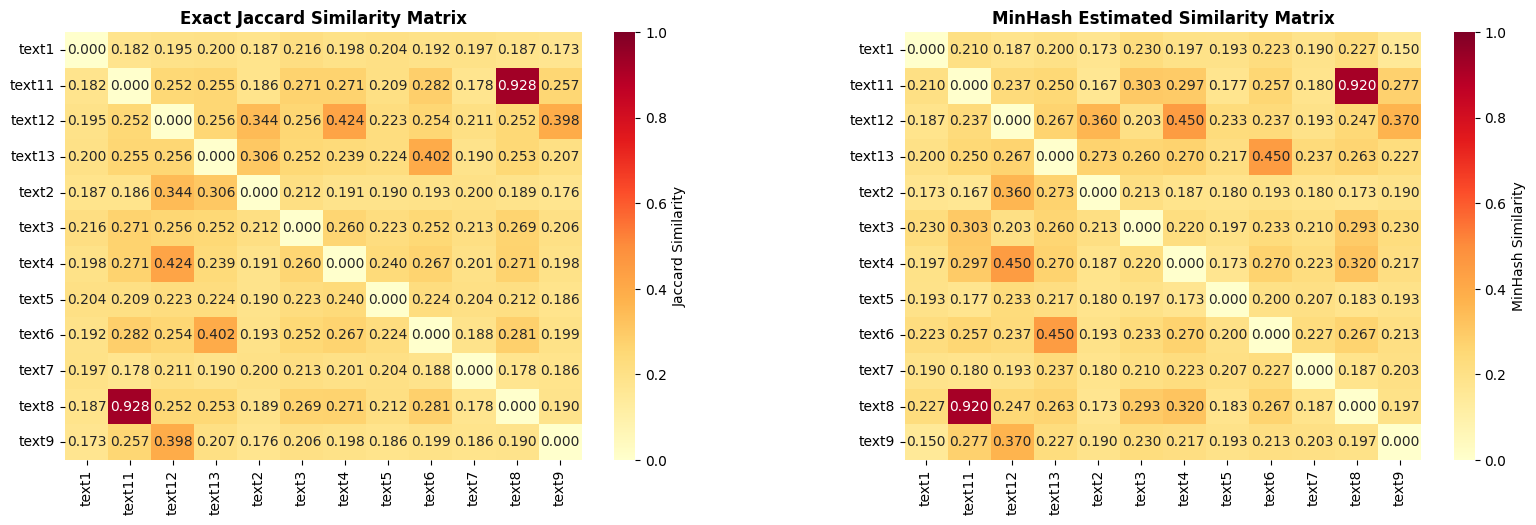

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

pairs = list(jaccard_similarities.keys())
doc_names = sorted(set([doc for pair in pairs for doc in pair]))

# Prepare similarity matrices
jaccard_matrix = np.zeros((len(doc_names), len(doc_names)))
minhash_matrix = np.zeros((len(doc_names), len(doc_names)))
error_matrix = np.zeros((len(doc_names), len(doc_names)))

for pair, jaccard_val in jaccard_similarities.items():
    i, j = doc_names.index(pair[0]), doc_names.index(pair[1])
    jaccard_matrix[i, j] = jaccard_val
    jaccard_matrix[j, i] = jaccard_val
    minhash_val = estimated_similarities.get(pair, 0.0)
    minhash_matrix[i, j] = minhash_val
    minhash_matrix[j, i] = minhash_val
    error_matrix[i, j] = abs(jaccard_val - minhash_val)
    error_matrix[j, i] = error_matrix[i, j]

short_names = [name.replace('.txt', '') for name in doc_names]

fig = plt.figure(figsize=(30, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Jaccard Similarity Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(jaccard_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=short_names, yticklabels=short_names,
            cbar_kws={'label': 'Jaccard Similarity'}, ax=ax1, vmin=0, vmax=1)
ax1.set_title('Exact Jaccard Similarity Matrix', fontsize=12, fontweight='bold')

# Plot 2: MinHash Similarity Heatmap
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(minhash_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=short_names, yticklabels=short_names,
            cbar_kws={'label': 'MinHash Similarity'}, ax=ax2, vmin=0, vmax=1)
ax2.set_title('MinHash Estimated Similarity Matrix', fontsize=12, fontweight='bold')


Text(0.5, 1.0, 'Absolute Error (Jaccard - MinHash)')

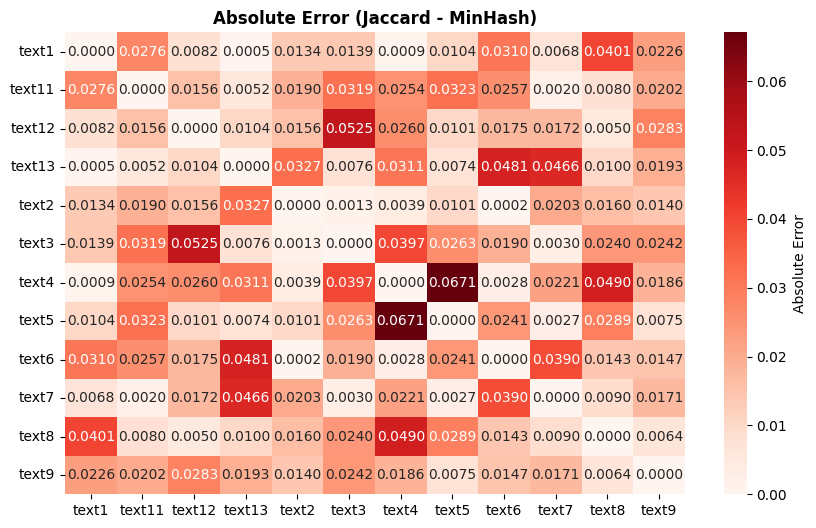

In [9]:
# Plot Error Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(error_matrix, annot=True, fmt='.4f', cmap='Reds',
            xticklabels=short_names, yticklabels=short_names,
            cbar_kws={'label': 'Absolute Error'}, ax=ax, vmin=0)
ax.set_title('Absolute Error (Jaccard - MinHash)', fontsize=12, fontweight='bold')

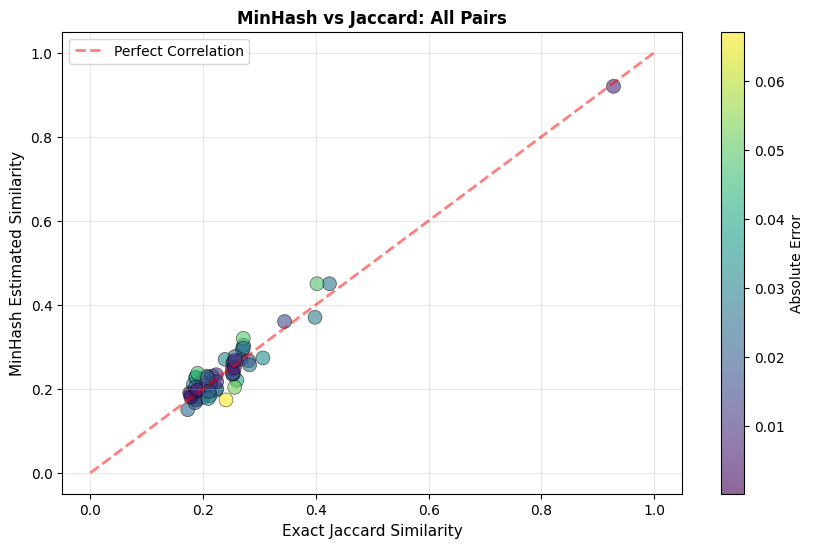

In [10]:
# Scatter plot with correlation
fig, ax = plt.subplots(figsize=(10, 6))
jaccard_values = [jaccard_similarities[pair] for pair in pairs]
minhash_values = [estimated_similarities.get(pair, 0.0) for pair in pairs]
errors = [abs(j - m) for j, m in zip(jaccard_values, minhash_values)]

ax.scatter(jaccard_values, minhash_values, s=100, alpha=0.6, 
            c=errors, cmap='viridis', edgecolors='black', linewidth=0.5)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=2, label='Perfect Correlation')
ax.set_xlabel('Exact Jaccard Similarity', fontsize=11)
ax.set_ylabel('MinHash Estimated Similarity', fontsize=11)
ax.set_title('MinHash vs Jaccard: All Pairs', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Absolute Error', fontsize=10)

### Step 6: Locality-Sensitive Hashing (LSH)

The **LSH** class splits each MinHash signature into a configurable number of bands (e.g., 30 bands of 10 rows each). Within each band, signatures are hashed into buckets, documents landing in the same bucket for any band become candidate pairs.

This process dramatically narrows down the number of pairs requiring full similarity checks, focusing attention on those most likely to be similar (above the LSH-derived similarity threshold (t)).

The LSH threshold \( t \) for candidate pairs is approximately computed as:
 
 $$
 t = \left( \frac{1}{\mathrm{num\_bands}} \right)^{1/\mathrm{rows\_per\_band}}
 $$
 
This threshold represents the estimated similarity value above which document pairs are likely to become LSH candidates for further comparison.


After retrieving LSH candidate pairs, we compare their estimated and exact Jaccard similarities to evaluate LSH effectiveness and accuracy.

In [11]:
# Step 6: LSH
print(f"Step 6: Building LSH index ({num_bands} bands, {rows_per_band} rows per band)...")
lsh = LSH(num_bands=num_bands, rows_per_band=rows_per_band)
lsh.index(signatures)
threshold = lsh.compute_threshold()

print(f"LSH similarity threshold: {threshold:.4f}")
print()

# Find candidate pairs
candidate_pairs = lsh.find_all_candidate_pairs()
print(f"Found {len(candidate_pairs)} candidate pairs from LSH:")
for doc1, doc2 in candidate_pairs:
    exact_sim = jaccard_similarities.get((doc1, doc2), 0.0)
    estimated_sim = estimated_similarities.get((doc1, doc2), 0.0)
    print(f"  {doc1} vs {doc2}: Jaccard={exact_sim:.4f}, Estimated={estimated_sim:.4f}")
print()

print("=" * 70)
print("Pipeline completed successfully!")
print("=" * 70)


Step 6: Building LSH index (30 bands, 10 rows per band)...
LSH similarity threshold: 0.7117

Found 1 candidate pairs from LSH:
  text11.txt vs text8.txt: Jaccard=0.9280, Estimated=0.9200

Pipeline completed successfully!


In [12]:
lsh_configs = [
    (15, 20),  
    (60, 6),   
    (120, 5),
    (150, 4)
]

print("=== LSH Parameter Sweep ===")
for num_bands, rows_per_band in lsh_configs:
    lsh = LSH(num_bands=num_bands, rows_per_band=rows_per_band)
    lsh.index(signatures)
    threshold = lsh.compute_threshold()
    candidate_pairs = lsh.find_all_candidate_pairs()

    print(f"\n# bands={num_bands}, rows={rows_per_band}, threshold≈{threshold:.2f}")
    if not candidate_pairs:
        print("candidate_pairs: []")
        continue

    print("candidate_pairs:")
    for doc1, doc2 in candidate_pairs:
        print(f"  ({doc1}, {doc2})")

=== LSH Parameter Sweep ===

# bands=15, rows=20, threshold≈0.87
candidate_pairs:
  (text11.txt, text8.txt)

# bands=60, rows=6, threshold≈0.51
candidate_pairs:
  (text11.txt, text8.txt)
  (text12.txt, text9.txt)

# bands=120, rows=5, threshold≈0.38
candidate_pairs:
  (text11.txt, text8.txt)
  (text12.txt, text4.txt)
  (text12.txt, text9.txt)
  (text13.txt, text2.txt)
  (text13.txt, text6.txt)

# bands=150, rows=4, threshold≈0.29
candidate_pairs:
  (text1.txt, text13.txt)
  (text11.txt, text8.txt)
  (text11.txt, text9.txt)
  (text12.txt, text2.txt)
  (text12.txt, text4.txt)
  (text12.txt, text9.txt)
  (text13.txt, text6.txt)
  (text2.txt, text7.txt)
  (text3.txt, text6.txt)


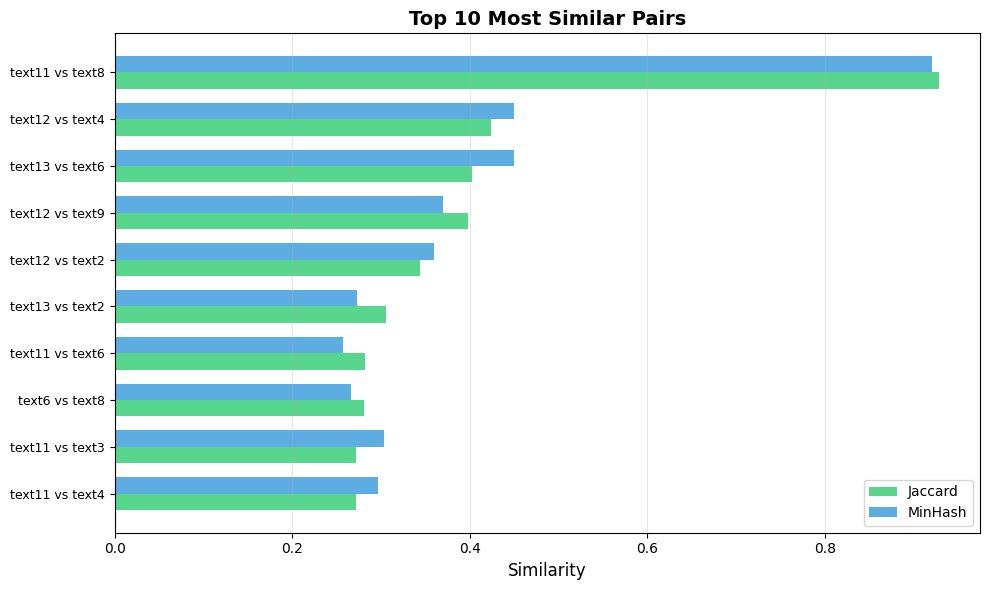

In [ ]:
# Top 10 most similar pairs
fig_top, ax_top = plt.subplots(figsize=(10, 6))

top_pairs = sorted(zip(pairs, jaccard_values, minhash_values), key=lambda x: x[1], reverse=True)[:10]
top_pairs = top_pairs[::-1]
top_jaccard = [j for _, j, _ in top_pairs]
top_minhash = [m for _, _, m in top_pairs]

x_pos = np.arange(len(top_pairs))
width = 0.35
ax_top.barh(x_pos - width/2, top_jaccard, width, label='Jaccard', alpha=0.8, color='#2ecc71')
ax_top.barh(x_pos + width/2, top_minhash, width, label='MinHash', alpha=0.8, color='#3498db')
ax_top.set_yticks(x_pos)
ax_top.set_yticklabels([f"{p[0].replace('.txt', '')} vs {p[1].replace('.txt', '')}" for p, _, _ in top_pairs],
                       fontsize=9)
ax_top.set_xlabel('Similarity', fontsize=12)
ax_top.set_title('Top 10 Most Similar Pairs', fontsize=14, fontweight='bold')
ax_top.legend(fontsize=10)
ax_top.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

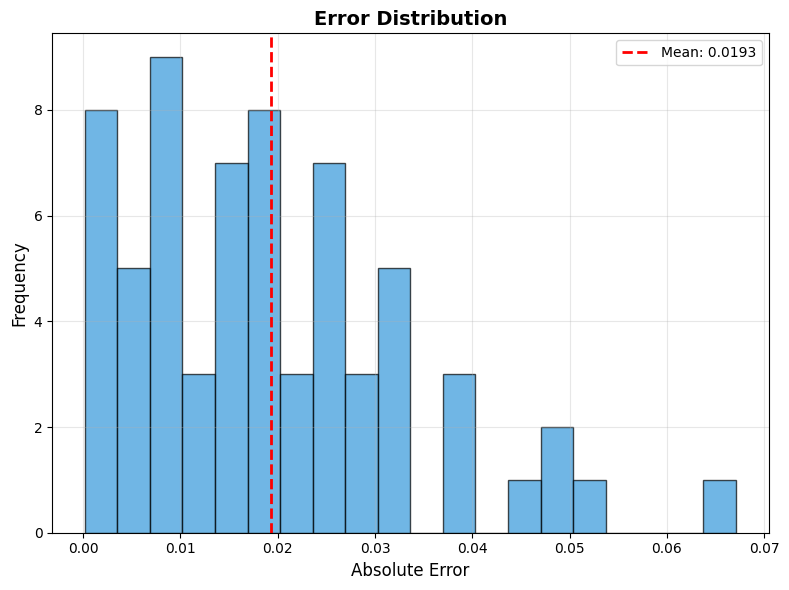

In [ ]:
# Error distribution
fig_error, ax_error = plt.subplots(figsize=(8, 6))
ax_error.hist(errors, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
ax_error.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, 
                 label=f'Mean: {np.mean(errors):.4f}')
ax_error.set_xlabel('Absolute Error', fontsize=12)
ax_error.set_ylabel('Frequency', fontsize=12)
ax_error.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax_error.legend(fontsize=10)
ax_error.grid(alpha=0.3)

plt.tight_layout()
plt.show()